This notebook attempts to study on the given flight delay claim dataset from 2013/01 to 2016/07, which a model would be built to predict claim amount of future flights.

In [80]:
# Used libraries
import pandas as pd
from datetime import datetime, timedelta

%matplotlib notebook

In [2]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data.csv')

# Check data size
data_df.shape

(899114, 10)

In [3]:
# Show some sample data
data_df.head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0


# Preliminary studies

We first study the basics of the given dataset:

In [4]:
# Check cardinality of different columns
data_df.apply(pd.Series.nunique)

flight_id      899114
flight_no        2344
Week               52
Departure           1
Arrival           163
Airline           122
std_hour           24
delay_time        379
flight_date      1065
is_claim            2
dtype: int64

In [5]:
# Check is_claim column values
data_df.is_claim.unique()

array([  0, 800], dtype=int64)

In [6]:
# Inspect records for is_claim that are not zero
data_df[~(data_df['is_claim'] == 0)].sort_values(['delay_time'], ascending=False).head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
69,1582680,CX5974,19,HKG,PEK,CX,16,Cancelled,2014-05-12,800
535145,1665338,DL282,10,HKG,SEA,DL,13,Cancelled,2016-03-08,800
536233,1668673,CA6532,34,HKG,WUH,CA,8,Cancelled,2015-08-23,800
536228,1668656,KA1102,29,HKG,PEK,KA,12,Cancelled,2014-07-18,800
536181,1668493,CA710,19,HKG,TSN,CA,18,Cancelled,2015-05-13,800


In [7]:
# For records that declared the claim and is due to delay, check delay_time statistics
data_df[~(data_df['is_claim'] == 0) & ~(data_df['delay_time'] == 'Cancelled')]['delay_time'].apply(lambda x: float(x)).describe()

count    13721.000000
mean         6.977480
std          5.156125
min          3.000000
25%          3.500000
50%          4.500000
75%          8.200000
max         24.300000
Name: delay_time, dtype: float64

Some highlights from the basic study:
- All records are departed from HKG, and arrived to 163 different cities from 122 airlines
- is_claim only consists of two values in the dataset: 0 or 800
- When is_claim equals to 800, delay_time is either a real value >= 3.0, or marked as "Cancelled"

In [87]:
# Before proceeding the study, create new columns that helps with the dataset study

# flight date+year/month/day
data_df['flight_dt'] = data_df['flight_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_df['flight_year'] = data_df['flight_dt'].apply(lambda x: x.year)
data_df['flight_month'] = data_df['flight_dt'].apply(lambda x: x.month)
data_df['flight_day'] = data_df['flight_dt'].apply(lambda x: x.day)

# flight_type: With three categories (Normal/Cancelled/Delayed)
def get_flight_type(delay_time):
    if delay_time == "Cancelled":
        return "Cancelled"
    elif float(delay_time) >= 3.0:
        return "Delayed"
    else:
        return "Normal"
    
data_df['flight_type'] = data_df['delay_time'].apply(get_flight_type)

In [184]:
# Check resulting dataframe
data_df.sample(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,flight_dt,flight_year,flight_month,flight_day,flight_type
18595,56725,BI636,26,HKG,BWN,BI,14,0.0,2014-06-30,0,2014-06-30,2014,6,30,Normal
593679,1846521,AA8919,28,HKG,ORD,AA,18,Cancelled,2015-07-11,800,2015-07-11,2015,7,11,Cancelled
595018,1850621,ET609,26,HKG,ADD,ET,0,1.4,2014-06-30,0,2014-06-30,2014,6,30,Normal
310652,967268,JL7038,9,HKG,NGO,JL,16,0.7,2016-02-26,0,2016-02-26,2016,2,26,Normal
630156,1959447,CX6503,13,HKG,USM,CX,16,-0.1,2015-03-30,0,2015-03-30,2015,3,30,Normal
584326,1817857,CI934,10,HKG,KHH,CI,10,0.1,2015-03-05,0,2015-03-05,2015,3,5,Normal
300950,935980,JL7058,20,HKG,TPE,JL,14,0.2,2014-05-18,0,2014-05-18,2014,5,18,Normal
551399,1715781,CX504,21,HKG,NRT,CX,9,0.5,2016-05-26,0,2016-05-26,2016,5,26,Normal
890207,2765501,S74865,38,HKG,BKK,S7,22,Cancelled,2013-09-22,800,2013-09-22,2013,9,22,Cancelled
611394,1901599,BA4551,34,HKG,AKL,BA,21,3.0,2015-08-26,0,2015-08-26,2015,8,26,Delayed


In below section, we study the dataset using various graphs, and try to have some impressions on how the data denotes for claiming risk:

# Time-series study for all flights

<IPython.core.display.Javascript object>


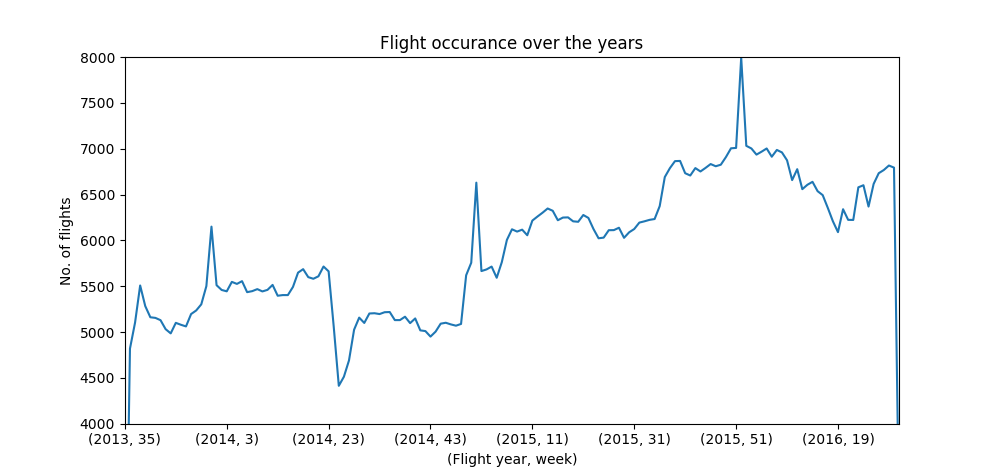

In [37]:
# Show flight row count against year + week
ax = data_df.groupby(['flight_year', 'Week']).count()['flight_id'].plot(
    title="Flight occurance over the years",
    ylim=(4000, 8000)
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of flights")

<IPython.core.display.Javascript object>


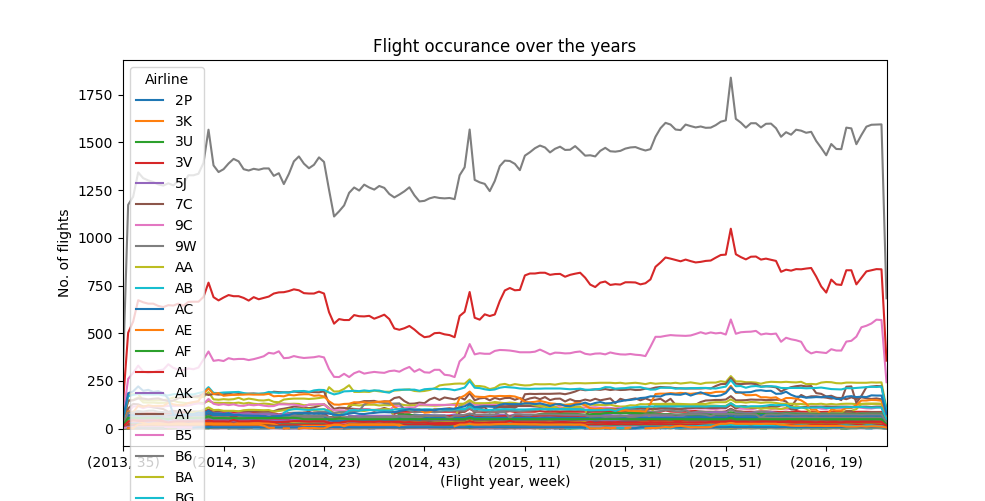

In [28]:
# Breakdown of flight occurance per airline
ax = data_df.groupby(['flight_year', 'Week', 'Airline']).count()['flight_id'].unstack().plot(
    title="Flight occurance over the years"
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of flights")

<IPython.core.display.Javascript object>


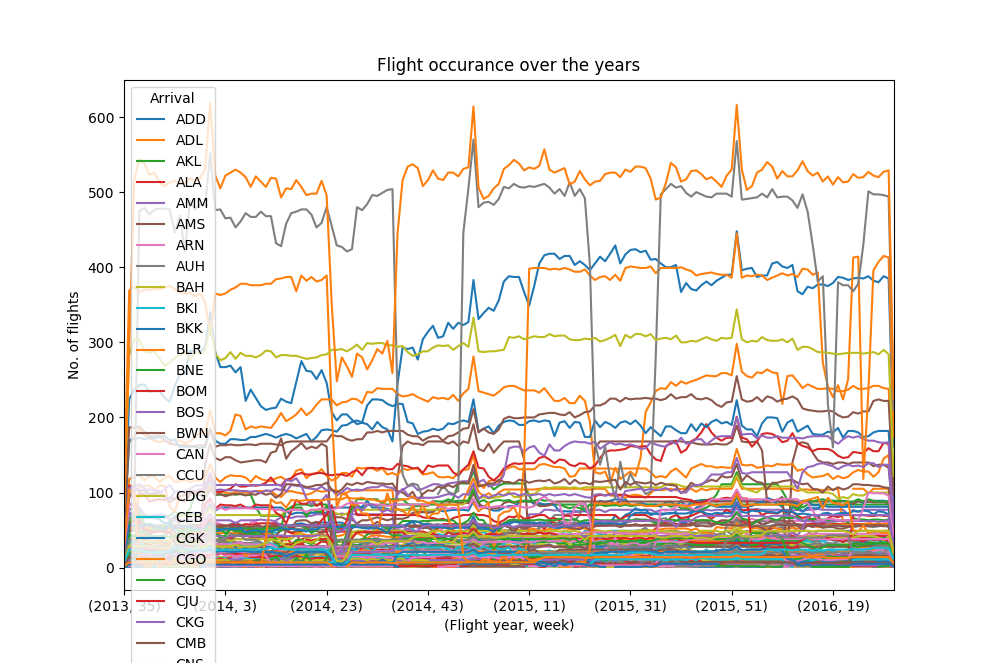

In [41]:
# Breakdown of flight occurance per arrival airport
ax = data_df.groupby(['flight_year', 'Week', 'Arrival']).count()['flight_id'].unstack().plot(
    title="Flight occurance over the years"
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of flights")

We saw that there is a seasonal trend for arranged flights during different weeks of a year (e.g. There is a peak of flights during year-end). Also, the increasing trend of arranged flights is more likely due to arrival airport rather than changes in airline comapanies.

# Time-series study for delay/cancel flights

In [ ]:
# See if there presents time-series trend on abnormal flights
abnormal_df = data_df[~(data_df['flight_type'] == "Normal")]

<IPython.core.display.Javascript object>


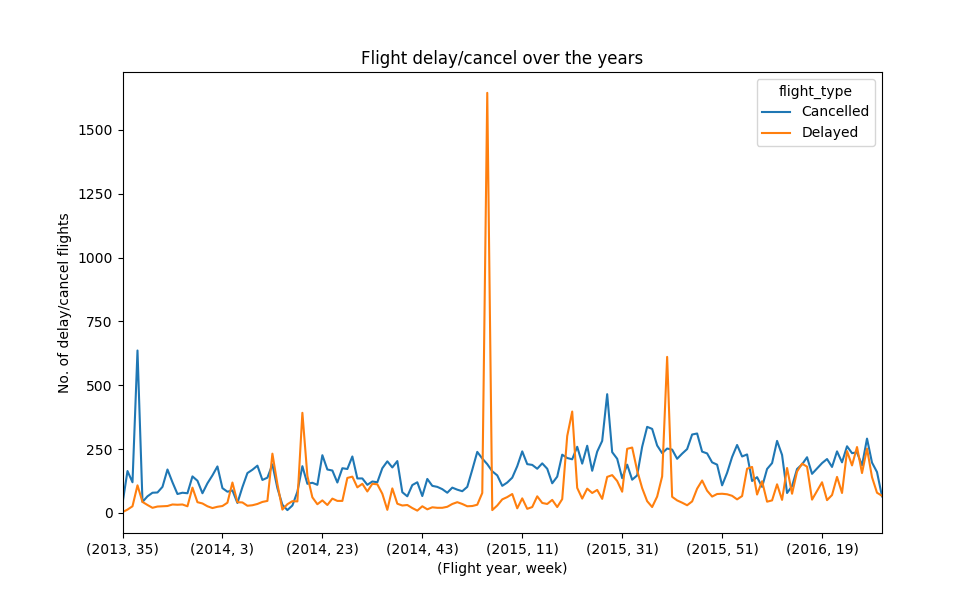

In [42]:
ax = abnormal_df.groupby(['flight_year', 'Week', 'flight_type']).count()['flight_id'].unstack().plot.line(
    title="Flight delay/cancel over the years"
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of delay/cancel flights")

<IPython.core.display.Javascript object>


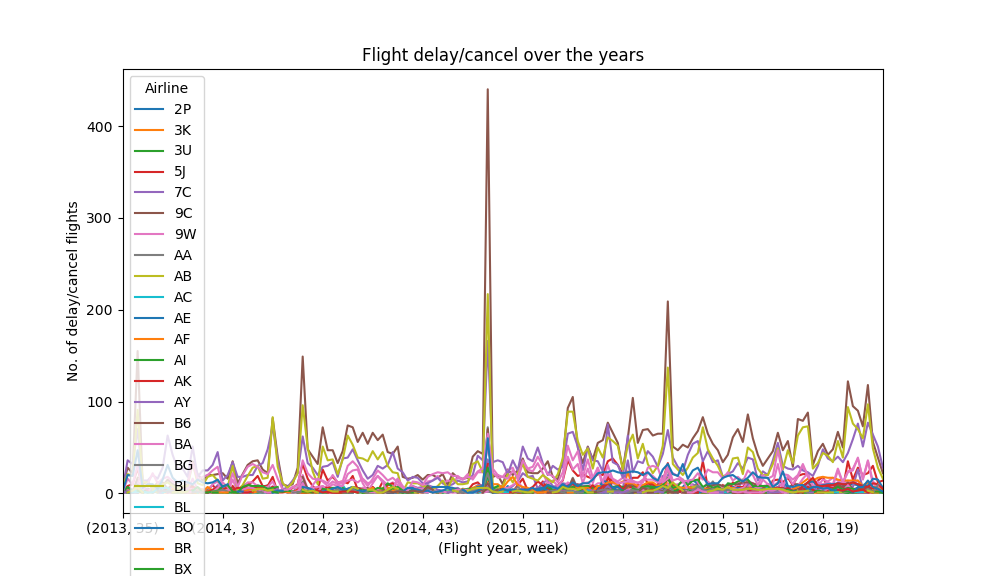

In [44]:
# Breakdown of abnormal flights trends per airline
ax = abnormal_df.groupby(['flight_year', 'Week', 'Airline']).count()['flight_id'].unstack().plot.line(
    title="Flight delay/cancel over the years"
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of delay/cancel flights")

<IPython.core.display.Javascript object>


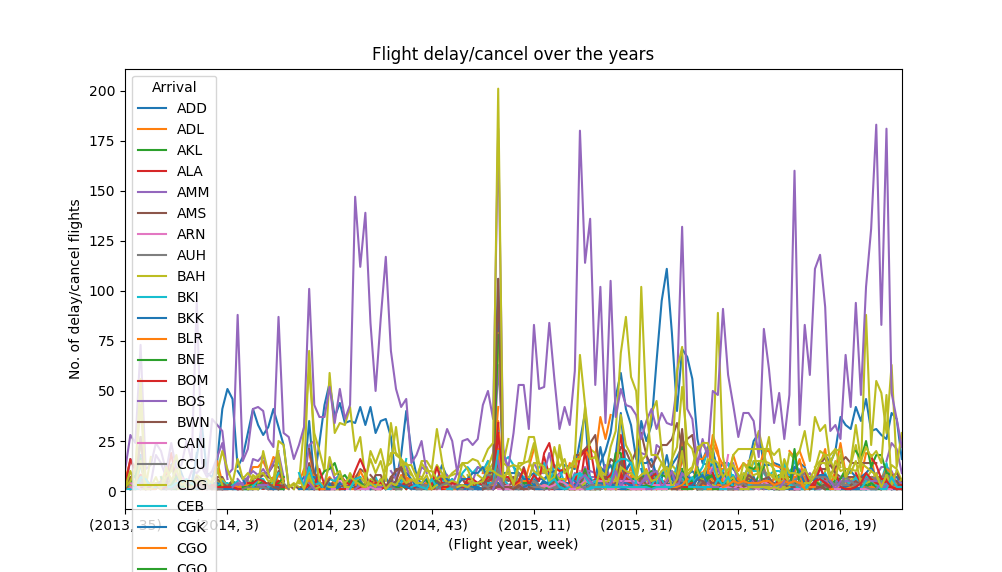

In [45]:
# Breakdown of abnormal flights trends per arrival airport
ax = abnormal_df.groupby(['flight_year', 'Week', 'Arrival']).count()['flight_id'].unstack().plot.line(
    title="Flight delay/cancel over the years"
)
ax.set_xlabel("(Flight year, week)")
ax.set_ylabel("No. of delay/cancel flights")

In [168]:
# 2013 Sept
# Related news on super typhoon
# Source: https://www.scmp.com/news/hong-kong/article/1315301/typhoon-usagi-severe-storm-lashes-hong-kong
# http://www.hko.gov.hk/m/article_e.htm?title=ele_00459
typhoon_df.groupby(['flight_dt', 'std_hour', 'flight_type']).count()['flight_id'].plot.line(rot=270)

<IPython.core.display.Javascript object>


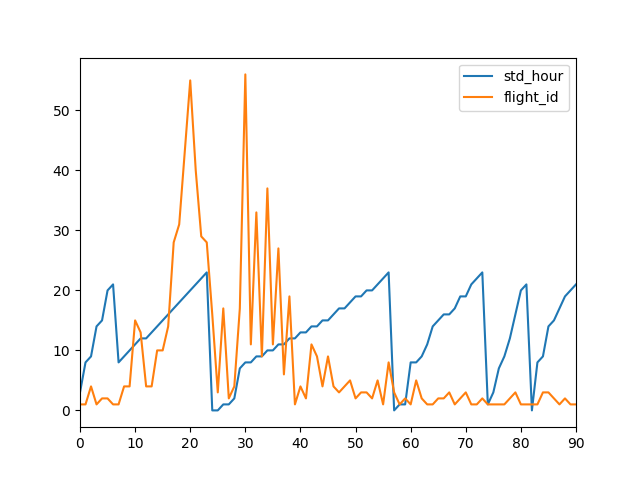

In [203]:
typhoon_df = abnormal_df[(abnormal_df['flight_dt'] >= datetime(2013,9,21)) & (abnormal_df['flight_dt'] <= datetime(2013,9,26))]
typhoon_df.groupby(['flight_dt', 'std_hour', 'flight_type']).count()['flight_id'].reset_index().plot()

Note: It is hard to linkage all possible information that causes delay/cancellation.

Throughout the years, there are almost always having delay/cancel flights, and there are several major incidents that result in such a surge. 

When the surge of delay/cancel flights occurs, it can be seen from the graphs that usually all airlines (and arrival ports) appeared similar surge trend. Implying that the large surge is likely due to departure airport rather than airlines (and arrival ports) themselves. Thus, there shall be features of departure port information that helps predict if a flight is about to be delayed/cancelled.

There could also be significant delay/cancel per individual arrival airport. For the predictive model, it shall have metrics of arrival airport information as well.

We should also bear in mind that:
- The surge of delay/cancel flights is related with distribution of flights' arrival ports
- The surge of delay/cancel flights is also related with airlines. Airlines themselves can be a factor of delay/cancel flights (e.g. faulty system within airline/mis-management/etc.)

Another finding is the irregularity of delay/cancel flight when shown as time series. The implication is that feature engineering efforts would be needed instead of solely using per flight record information as prediction features.

# Distribution study on flight hours

<IPython.core.display.Javascript object>


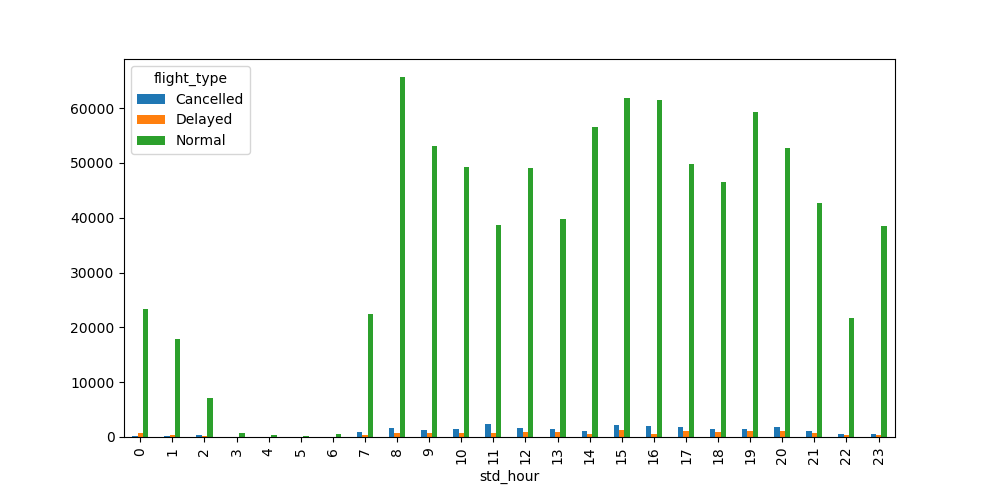

In [167]:
data_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].unstack().plot.bar()

<IPython.core.display.Javascript object>


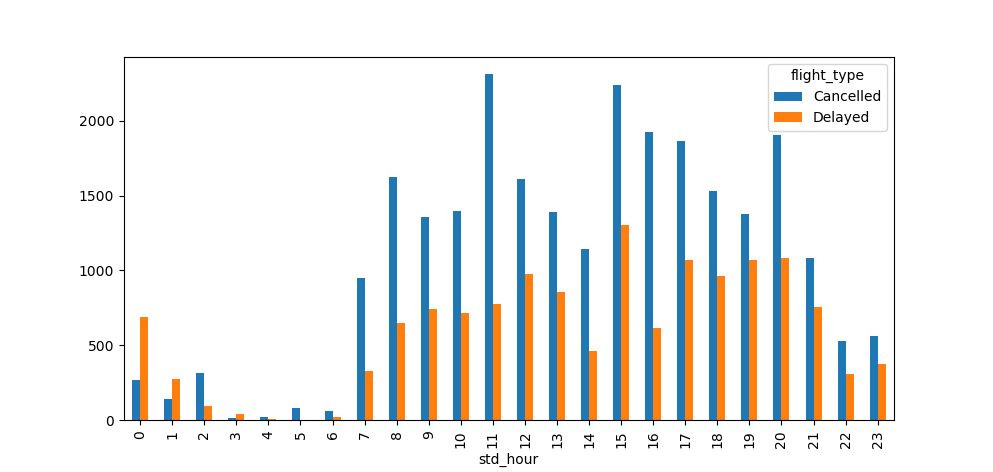

In [61]:
abnormal_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].unstack().plot.bar()

In [65]:
data_count_df = data_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].reset_index()

<IPython.core.display.Javascript object>


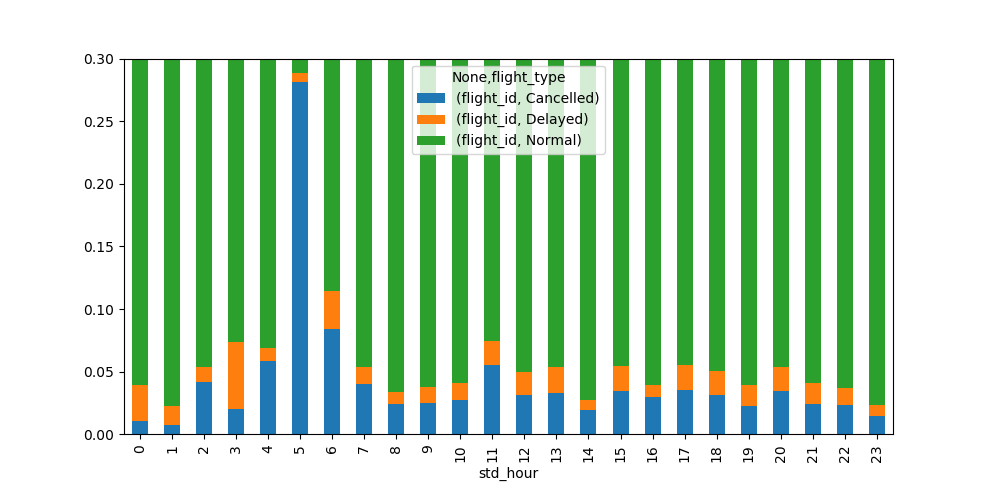

In [73]:
tps = data_count_df.pivot_table(values=['flight_id'], 
                          index='std_hour',
                          columns='flight_type',
                          aggfunc='sum')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True, ylim=(0, 0.3))

The 100% stacked bar shows the hour trend better as it considers ratio of different flight types rather than just by count. The graph can be mis-representive for std_hour = 4 as there are much less flights happened during that hour.

# Detailed inspection of per-hour effect to delay/cancel flights

One assumption is that flights should usually start at scheduled hours, and rare occurance of std_hour could mean abnormalities of flight arrangement that could result in delays/cancel. In here, individual arrival airports are inspected for the per-hour effect.

In [155]:
# Check arrival airport std_hour throughout the years
# The result is shown as 100% stack bar (for distribution of std_hour per year+month)

def check_arrival_std_hour_dist(arrival_airport):
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "All flights std_hour ratio of " + arrival_airport
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show only normal flights
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['flight_type'] == "Normal") &
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Normal flights std_hour ratio of " + arrival_airport
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show only abnormal flights
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[ ~(data_count_df['flight_type'] == 'Normal') &
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Abormal flights std_hour ratio of arrival " + arrival_airport
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show abnormal flights per-hour distribution
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['std_hour'],
                              columns='flight_type',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Abormal flights per std_hour of " + arrival_airport
    tps.plot(kind='bar', stacked=True, title=the_title)

In [156]:
def check_arrival_airline_std_hour_dist(arrival_airport, airline):
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Airline'] == airline) & 
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "All flights std_hour ratio of (" + arrival_airport + "," + airline + ")"
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show only normal flights
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Airline'] == airline) & 
                                (data_count_df['flight_type'] == "Normal") &
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Normal flights std_hour ratio of (" + arrival_airport + "," + airline + ")"
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show only abnormal flights
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Airline'] == airline) & 
                                ~(data_count_df['flight_type'] == 'Normal') &
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['flight_year', 'flight_month'],
                              columns='std_hour',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Abormal flights std_hour ratio of arrival (" + arrival_airport + "," + airline + ")"
    tps.plot(kind='bar', stacked=True, legend=False, title=the_title)

    # Show abnormal flights per-hour distribution
    data_count_df = data_df.groupby(['Airline', 'Arrival', 'flight_year', 'flight_month', 'std_hour', 'flight_type']).count()['flight_id'].reset_index()
    to_check_df = data_count_df[(data_count_df['Airline'] == airline) & 
                                (data_count_df['Arrival'] == arrival_airport)]
    tps = to_check_df.pivot_table(
                              values=['flight_id'], 
                              index=['std_hour'],
                              columns='flight_type',
                              aggfunc='sum')

    tps = tps.div(tps.sum(1), axis=0)
    the_title = "Abormal flights per std_hour of (" + arrival_airport + "," + airline + ")"
    tps.plot(kind='bar', stacked=True, title=the_title)

<IPython.core.display.Javascript object>


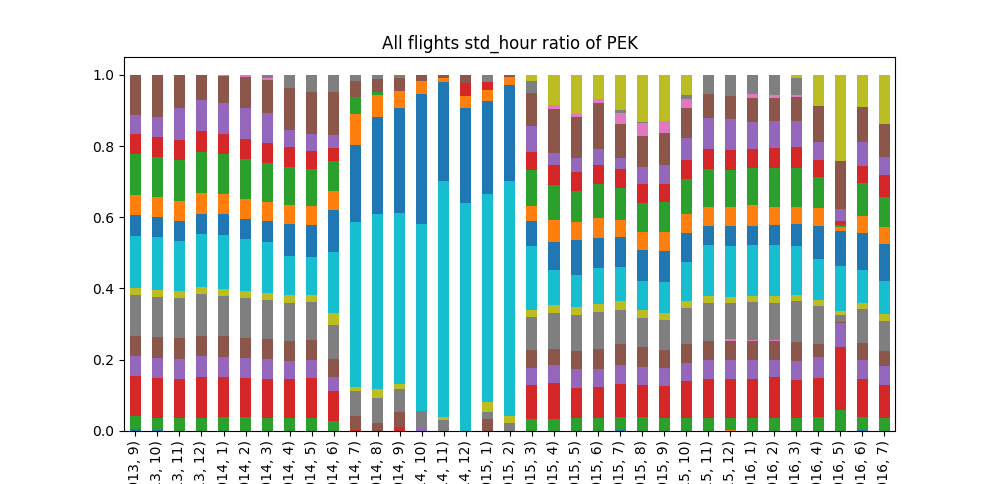

<IPython.core.display.Javascript object>


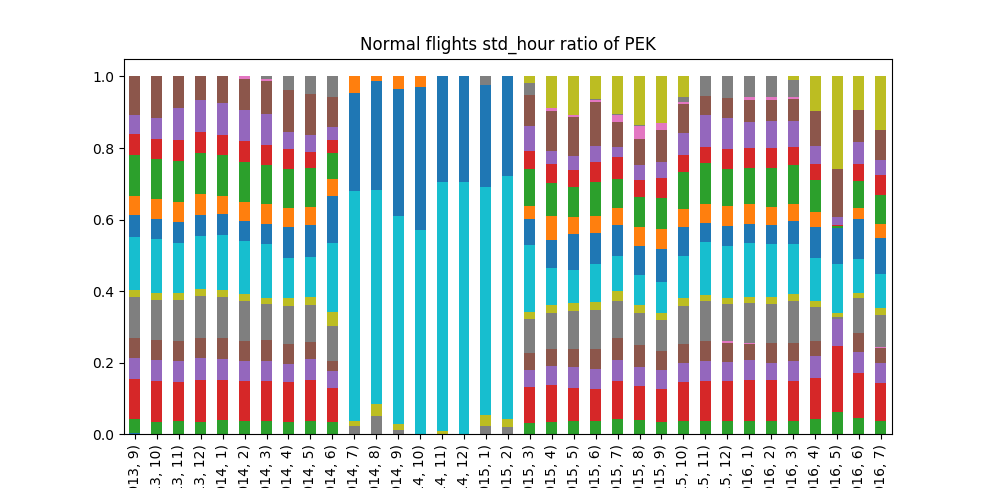

<IPython.core.display.Javascript object>


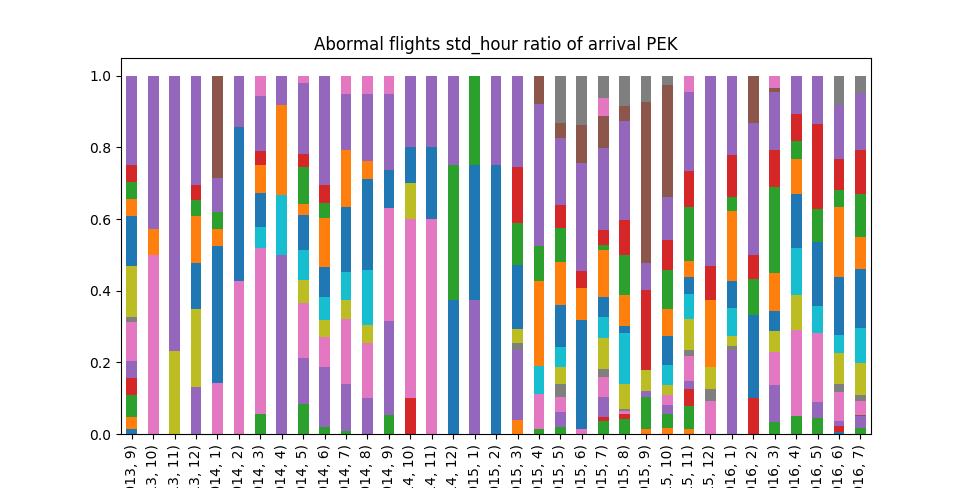

<IPython.core.display.Javascript object>


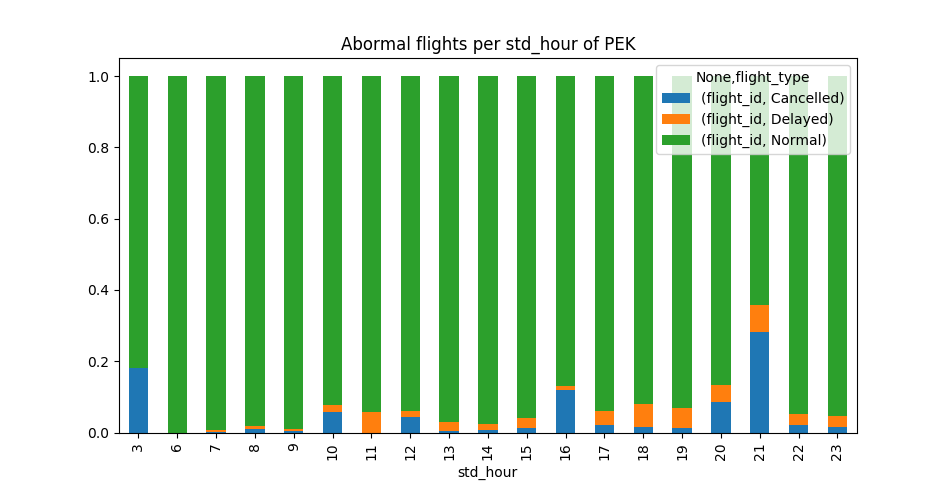

In [153]:
check_arrival_std_hour_dist("PEK")

<IPython.core.display.Javascript object>


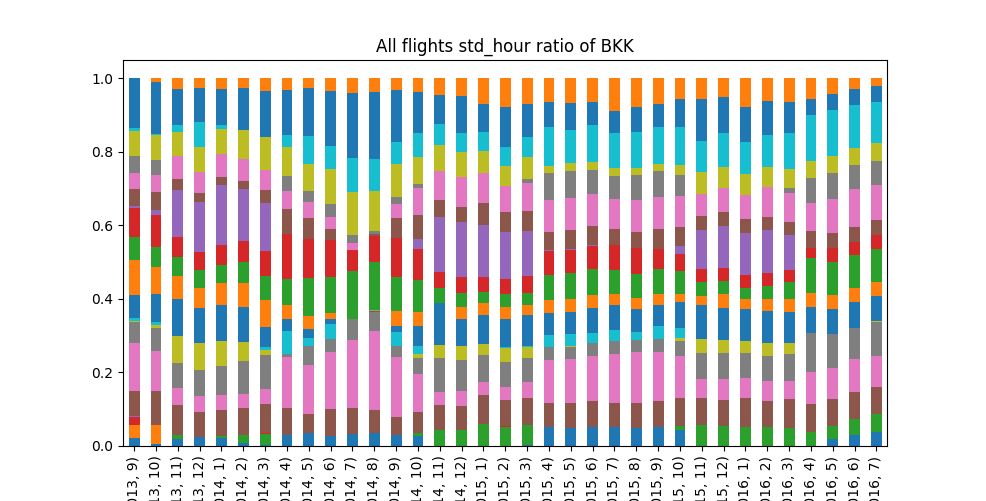

<IPython.core.display.Javascript object>


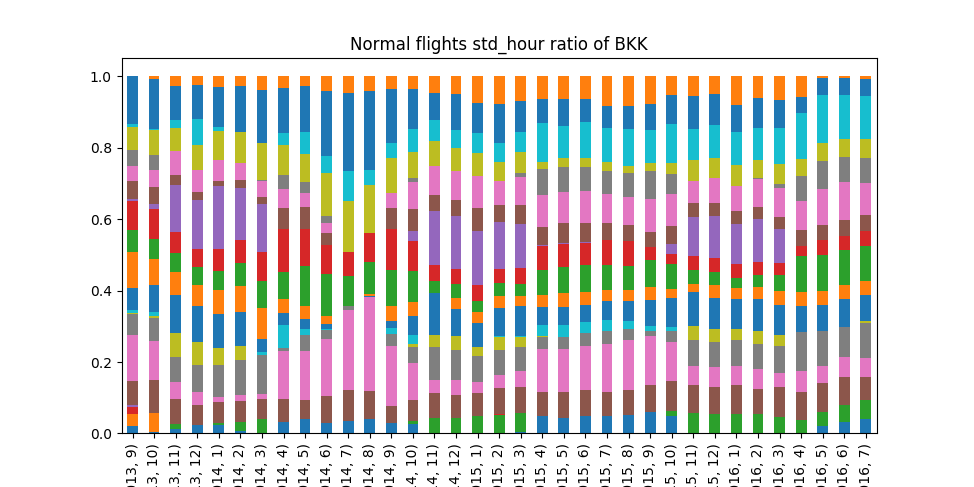

<IPython.core.display.Javascript object>


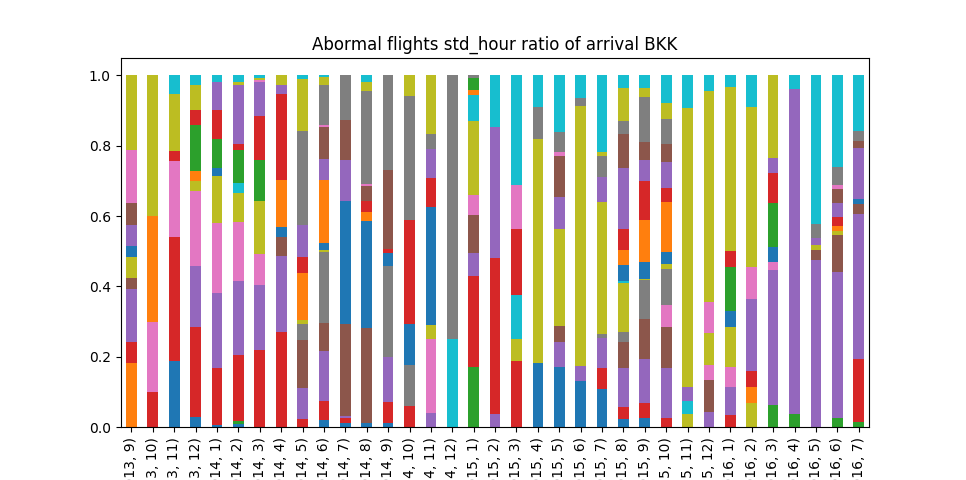

<IPython.core.display.Javascript object>


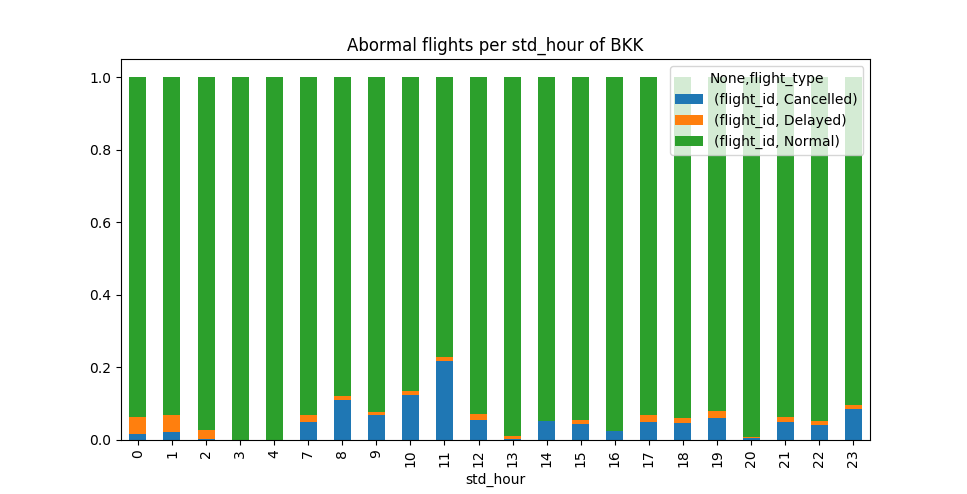

In [154]:
check_arrival_std_hour_dist("BKK")

In [161]:
data_df[data_df['Arrival'] == "BKK"]['Airline'].unique()

array(['S7', 'HX', 'CX', 'TG', 'PG', 'HM', 'AA', 'UL', 'MJ', 'EY', 'TK',
       'AC', 'O8', 'BI', 'KQ', 'AY', 'RJ', 'KA', 'UO', 'OX', 'NZ', 'EK',
       'MD', 'OZ', 'LD', 'PK', 'ET', 'E8', 'LY'], dtype=object)

<IPython.core.display.Javascript object>


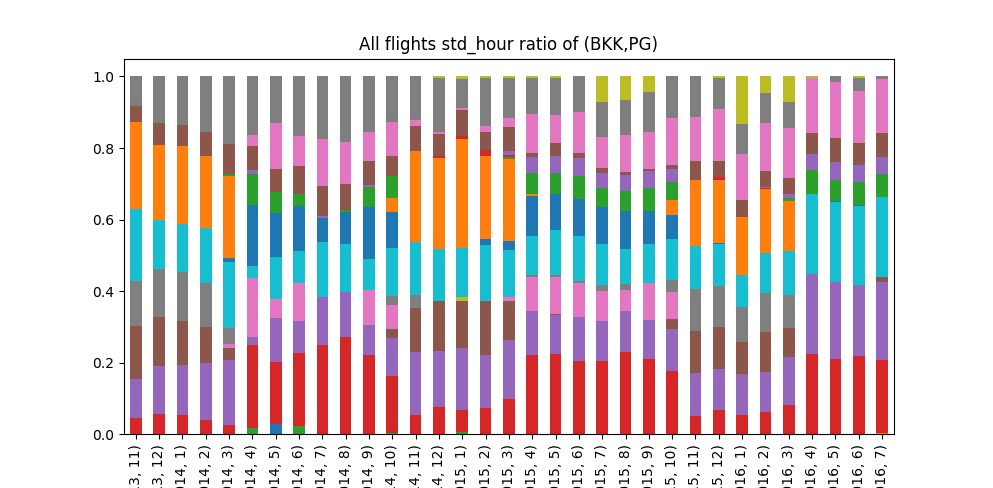

<IPython.core.display.Javascript object>


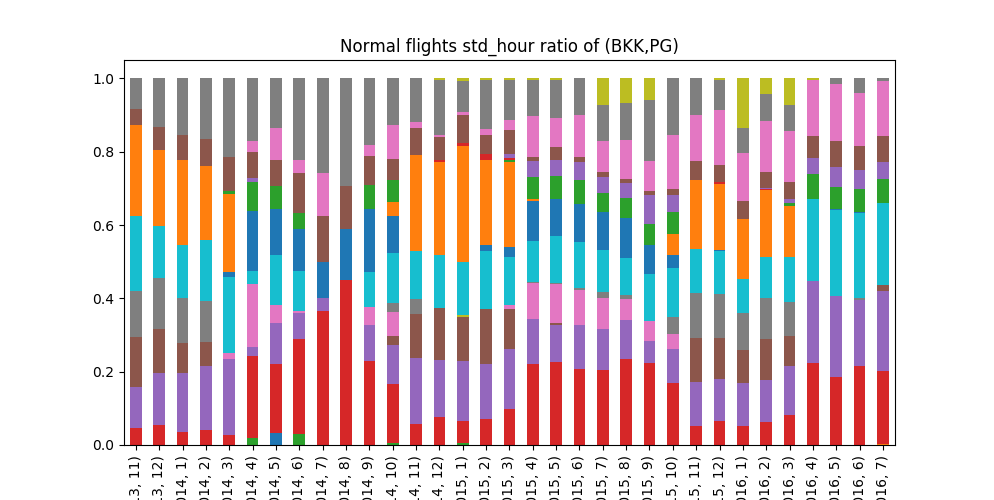

<IPython.core.display.Javascript object>


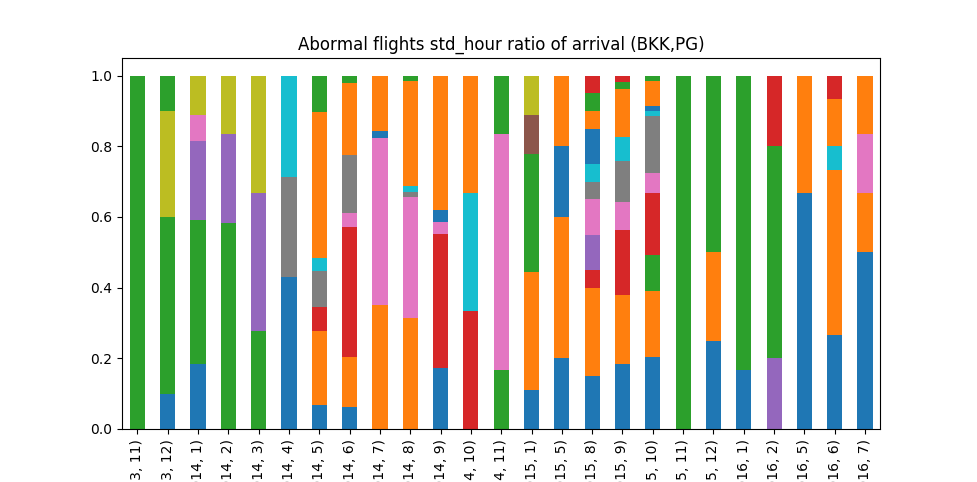

<IPython.core.display.Javascript object>


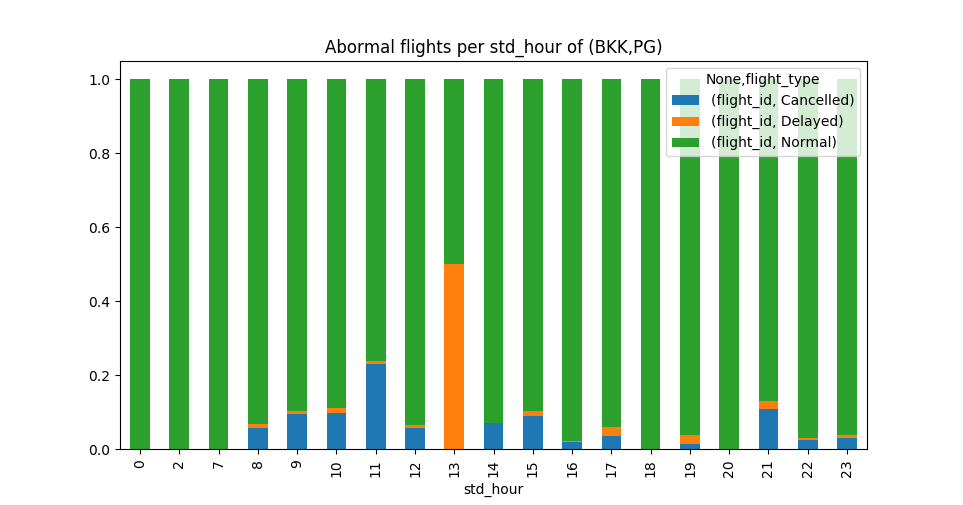

In [162]:
check_arrival_airline_std_hour_dist("BKK", "PG")

Some interesting findings from the inspection:
- There are trends of flight scheduled hours. Especially in BKK case, some hours would have more flights in certain months than others. The trend is further signified when a specific airline is chosen.
- In PEK case, July 2014 to Feb 2015, the flight schedule is not normal and some hours are not seen at all when filtered with normal flights only.
- In BKK + airline PG case, the delay/cancel rate is high for std_hour = 13, but it could be due to change in flight schedule during certain period instead of always having risk of delay/cancel when scheduled flight at 13:00.

In [ ]:
# From departure port
# Zoom in 2015 week 4 details + line chart on delay hours

# We know that delay_hours of course infers how risky to delay/cancellation, but we won't have that in runtime
# Instead, we can (at most) only have historical data in runtime

In [ ]:
# Other news on weather related airport affect: https://edition.cnn.com/2016/12/04/asia/china-smog-stranded/

In [ ]:
# Linkage with airport geo-location
# Assumption: Even if airport disrupted, could geo-location compensate for delay hours?
# BUT: Arrival airport code infers the geo-location already
# https://openflights.org/data.html

In [1]:
# Per arrival airport flight trend
# Not always constant, bear in mind if we use week number only (or preprocessing might even be needed for those gaps)
# e.g. PVG sudden drops in no. of flights
# Something related to this: https://www.scmp.com/news/hong-kong/economy/article/1846653/hong-kongs-cathay-pacific-cancels-some-mainland-china-flights

In [ ]:
# Arrival airport congestion could be a factor of delay
# https://www.forbes.com/sites/ralphjennings/2017/06/06/hogging-of-space-explains-why-so-many-flights-still-take-off-late-in-china/#3f1d750e2610

In [ ]:
# Fix arrival port = ICN
# Shows slump in 2015 week 24-40
# Breakdown by 100% stack bar -> basically all airlines are affected => cause could be due to arrival airport problem
# If we have a way to translate such signal with something like rolling window on the arrival airport?

In [2]:
# Departure port could also impose disruption
# e.g. 2015 week 4, many, many flights are delayed

In [ ]:
# Zoom in 2015 week 4 details
# Date + std_hour against delay/cancel count

# Shows that std_hour can be a useful feature to determine if a flight could be disrupted
# e.g. By 100% stack bar, less flight delay/cancel per "after 3pm" vs. midnight

Direct approach:
- Put week, Departure, Arrival, Airline, std_hour, predict delay_hours/is_claim with binary output * 800

Feature engineering approach:
- Last (4 hours/day/week/month) of (delay_hour rolling average) of (airline, departure, arrival)

Other links:

https://www.scmp.com/news/hong-kong/economy/article/2126184/best-and-worst-airlines-and-routes-revealed-database-26000
https://www.scmp.com/news/hong-kong/health-environment/article/2098076/can-you-fly-typhoon-heres-how-airlines-and